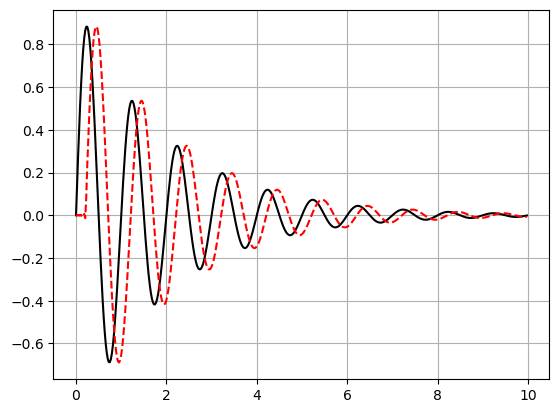

In [9]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

class AllPassDelayFilter(torch.nn.Module):
    def __init__(self,
                 LENFILTER=16, # number of taps in filter
                 Fs = 44100, # sampling rate in Hz
                 ):
        super().__init__()
        self.LENFILTER = LENFILTER
        self.Fs = Fs

    def forward(self, delay: torch.Tensor) -> torch.Tensor:
        '''
        input argument delay is in ms
        
        returns taps of all-pass FIR delay filter as a torch tensor
        '''

        tau = delay*1e-3*self.Fs # Delay [in samples].
        n = torch.arange(self.LENFILTER)
        # Compute sinc filter.
        h = torch.sinc(n - (self.LENFILTER - 1) / 2 - tau)
        # Multiply sinc filter by window
        h *= torch.signal.windows.kaiser(self.LENFILTER)
        # Normalize to get unity gain.
        h /= torch.sum(h)

        return h
    
DELAY = 0.2 #milliseconds
# Create sine wave to use for exploring time delay filter
frequency = 1000  # Frequency in Hz
sample_rate = 44100  # Sample rate in Hz
duration = 0.01  # Duration in seconds
# Calculate the time values
t = torch.arange(int(sample_rate * duration)) / sample_rate
# Generate the sine wave
signal = torch.exp(-t/0.002)*torch.sin(2 * torch.pi * frequency * t)

# Create delay filter
delayline = AllPassDelayFilter(LENFILTER=128)
fircoeffs = delayline(DELAY)

# apply filter to signal
delayed = torchaudio.functional.fftconvolve(signal,fircoeffs,mode='same')

# plot original and filtered signal
plt.plot(t*1000,signal,'k-',torch.arange(len(delayed))*1000/sample_rate,delayed,'r--')
plt.grid()
plt.show()


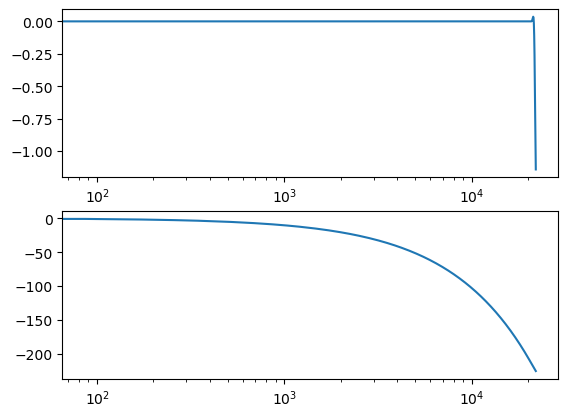

In [10]:
# frequency response
Hdel = torch.fft.fft(fircoeffs,512)
freq = torch.fft.fftfreq(512)
plt.subplot(2,1,1)
plt.semilogx(freq[:256]*44100,20*torch.log10(torch.abs(Hdel[:256])))
plt.subplot(2,1,2)
plt.semilogx(freq[:256]*44100,np.unwrap(torch.angle(Hdel[:256]).numpy()))

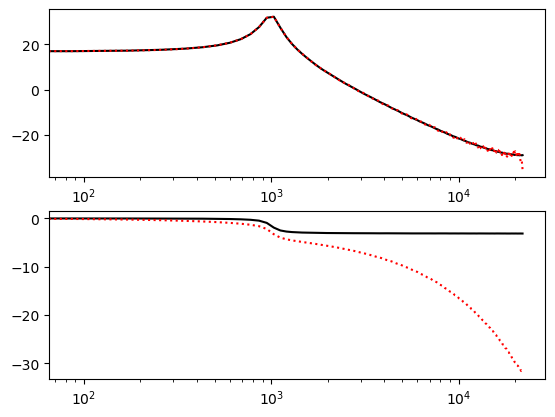

In [11]:
signalft = torch.fft.fft(signal,512)
delayedft = torch.fft.fft(delayed,512)
plt.subplot(2,1,1)
plt.semilogx(freq[:256]*44100,20*torch.log10(torch.abs(signalft[:256])),'k-',
             freq[:256]*44100,20*torch.log10(torch.abs(delayedft[:256])),'r:')
plt.subplot(2,1,2)
plt.semilogx(freq[:256]*44100,np.unwrap(torch.angle(signalft[:256]).numpy()),'k-',
             freq[:256]*44100,np.unwrap(torch.angle(delayedft[:256]).numpy()),'r:')